# Group 005 Real Estate Analysis

## Setup and Load Data

First, we retrieve the dataste from https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-20182021.

If using the below cell, make sure you have a Kaggle API token in a `kaggle.json` file in `~/.kaggle/`. Otherwise, please download the data manually and place it under a folder `./data/`.

In [1]:
# !mkdir data
# !kaggle datasets download mrdaniilak/russia-real-estate-20182021
# !mv ./russia-real-estate-20182021.zip ./data/russia-real-estate-20182021.zip

In [2]:
# import zipfile
# with zipfile.ZipFile('./data/russia-real-estate-20182021.zip', 'r') as zip_ref:
#     zip_ref.extractall('./data')

Now, we may proceed with exploration.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
DATA_CSV_PATH = './data/all_v2.csv'

# load csv data
df = pd.read_csv(DATA_CSV_PATH)

# remove duplicate data
df = df.drop_duplicates()

In [5]:
df.sample(5)

,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
5116905,5500000,2021-03-07,19:47:34,59.863518,30.188730,2661,2,20,20,1,40.4,9.3,1
2383334,2500000,2019-08-13,11:55:23,47.202026,39.619010,3230,1,1,5,2,47.0,6.0,1
2470066,3100000,2019-08-29,21:46:01,47.213966,39.636806,3230,3,2,5,3,64.0,6.5,1
3813540,1890000,2020-06-01,00:40:29,55.217396,61.282650,5282,1,6,10,2,60.0,9.0,11
780154,3500000,2018-12-21,18:14:48,47.261631,39.649253,3230,1,9,10,3,65.0,11.0,1


Note that this Kaggle Dataset was originally pulled from GeoNames (http://www.geonames.org/), which has its own "regions" separated by county. Our city of interest, Moscow, has ID 81.

Addtionally, we will give categorical data appropriate labels given by the dataset spec.

In [6]:
MOSCOW_CODE = 81
MAX_NUM_SAMPLES = 100000
SEED = 69

RUBLE_TO_DOLLAR = 0.012

moscow_df = df.loc[df['region'] == MOSCOW_CODE]
moscow_df = moscow_df.drop(['time', 'geo_lat', 'geo_lon', 'region'], axis=1)
moscow_df['date'] = moscow_df['date'].apply(lambda x: int(x[:4]))

moscow_df['object_type'] = moscow_df['object_type'].replace(1, 'preowned').replace(11, 'new')
moscow_df['building_type'] = moscow_df['building_type'].replace(0, 'other').replace(1, 'panel').replace(2, 'monolithic').replace(3, 'brick').replace(4, 'blocky').replace(5, 'wooden')

# -1 means studio apartment, so we replace with 0 (since studio apartments have no extra rooms)
# there are not other datapoints with value 0
moscow_df['rooms'] = moscow_df['rooms'].replace(-1, 0)

# remove rows with errorneous data
moscow_df = moscow_df[moscow_df['price'] >= 0]
moscow_df = moscow_df[moscow_df['rooms'] >= 0]
moscow_df['price'] = moscow_df['price'] * RUBLE_TO_DOLLAR

# cap number of elements
moscow_df = moscow_df.sample(MAX_NUM_SAMPLES, random_state=SEED)

In [7]:
moscow_df.isnull().values.any()

False

In [8]:
moscow_df.sample(5)

,price,date,building_type,level,levels,rooms,area,kitchen_area,object_type
2071718,16560.0,2019,brick,3,5,1,30.0,6.0,preowned
3948810,42600.0,2020,brick,1,16,1,34.9,9.5,preowned
1072289,28200.0,2019,panel,8,17,0,29.3,8.0,preowned
1349406,36600.0,2019,brick,4,5,1,33.0,9.3,preowned
2895453,30000.0,2019,brick,3,4,1,30.0,6.0,preowned


# Exploration

First, we'll look at the data distributions for the ordinal data.

In [9]:
moscow_df.describe()

,price,date,level,levels,rooms,area,kitchen_area
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,5.707663e+04,2019.310120,7.053700,12.752370,1.776320,51.592710,10.362995
std,3.556933e+04,0.880621,5.692804,7.411351,0.862656,21.748209,6.834285
min,1.800000e+01,2018.000000,1.000000,1.000000,0.000000,2.400000,0.120000
25%,3.600000e+04,2019.000000,3.000000,5.000000,1.000000,38.000000,7.000000
50%,5.160000e+04,2019.000000,5.000000,12.000000,2.000000,46.000000,9.700000
75%,7.140000e+04,2020.000000,10.000000,17.000000,2.000000,61.900000,12.000000
max,3.572896e+06,2021.000000,36.000000,38.000000,9.000000,997.000000,1131.000000


Each column is skewed right, meaning we have some extreme outliers for each column. This is because in the real estate market, while most "normal" places have a similar price, the price ceiling for real estate can be very high. While these outliers are sparse, they could still bias our model.

Next, we can plot each variable against price to look for possible correlations. We will only looks at data points with price less than $2 \cdot 10^7$ to get better plots by removing price outliers. We will also plot regression lines for each to quantify per-variable correlation strength.

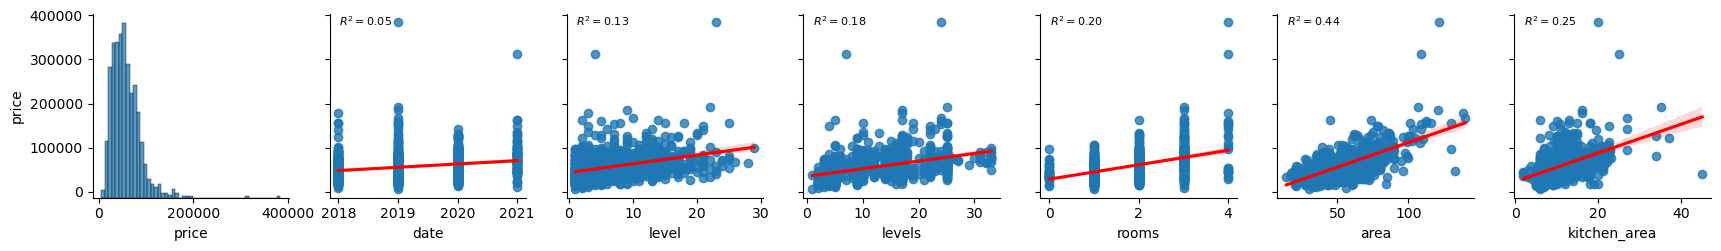

In [10]:
from scipy.stats import linregress

def calc_R2(x, y, ax=None, **kwargs):
    ax = ax or plt.gca()
    _, _, r_value, _, _ = linregress(x=x, y=y)
    ax.annotate(f'$R^2 = {r_value ** 2:.2f}$', xy=(.05, 1), xycoords=ax.transAxes, fontsize=8, ha='left', va='top')

g = sns.pairplot(moscow_df.loc[moscow_df['price'] < 2e7].sample(1000, random_state=21), kind='reg', y_vars=['price'], plot_kws={'line_kws':{'color':'red'}})

g.map_upper(calc_R2)
plt.show()

Data and level have near-zero correlations. The number of levels in the building (i.e. building size) and number of rooms, as well have kitchen area, seem like they might have some signidicance. The most important (single) variable seems to be area. However, even here we don't have a strong correlation. Hopefully combining these variables into a multivariate regression will lead to stronger correlation.

Additionally, all of the correlations seem to be closest to linear (as opposed to some polynomial fit). So, a polynomial regression may not perform better than a linear regression.

However, in the above we only use about 1000 samples (for efficiency). We can see these correlation results across the dataset more easily with a heatmap:

<Axes: >

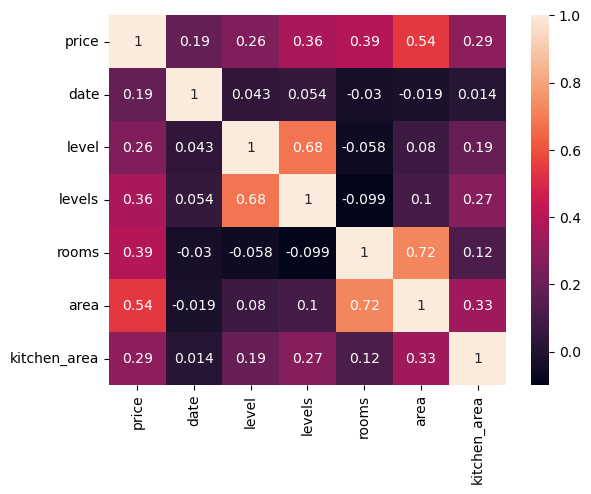

In [11]:
sns.heatmap(moscow_df.drop(['building_type', 'object_type'], axis=1).corr(), annot=True)

Notably, `date` and `level` have a stronger correlation than from our 1000 samples, but each individual variable still does not have a strong enough correlation for prediction.

Thus, we proceed to fitting some models.

## Model Fitting

In [12]:
from sklearn.model_selection import train_test_split

X = moscow_df[['date', 'building_type', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'object_type']]
y = moscow_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

print(f'{len(y_train)} train samples; {len(y_test)} test samples')

70000 train samples; 30000 test samples


Now, we will one-hot the categorical data using sklearn's one hot encoder.

In [13]:
from sklearn.preprocessing import OneHotEncoder

for col in ['building_type', 'object_type']:

    one_hot = OneHotEncoder()
    one_hot.fit(X_train[[col]])

    X_train.loc[:, one_hot.categories_[0]] = one_hot.transform(X_train[[col]]).todense()
    X_test.loc[:, one_hot.categories_[0]] = one_hot.transform(X_test[[col]]).todense()

    X_train = X_train.drop(col, axis=1)
    X_test = X_test.drop(col, axis=1)

X_train.sample(5)

,date,level,levels,rooms,area,kitchen_area,blocky,brick,monolithic,other,panel,wooden,new,preowned
4370284,2020,12,17,2,63.0,11.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3848980,2020,3,17,1,50.0,12.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5057886,2021,14,16,1,44.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3385069,2020,5,9,3,76.3,8.3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
589454,2018,8,9,1,45.0,9.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Next, we will scale the data. Note that not all models require scaled data; while models like linear regression require scaling to avoid overemphasis of certain datapoints, models like descision trees (and, by extension, random forests) are not affected by unscaled variables.

It is also important to note that scaled data won't *negatively* impact descision trees, but we make a copy of scaled data to more explicitly demonstrate model understanding.

In [14]:
from sklearn.preprocessing import StandardScaler

ordinal_cols = ['date', 'level', 'levels', 'rooms', 'area', 'kitchen_area']
X_train_ordinal, X_test_ordinal = X_train[ordinal_cols], X_test[ordinal_cols]

scaler = StandardScaler()
scaler.fit(X_train_ordinal)

X_train_scaled, X_test_scaled = X_train, X_test

X_train_scaled.loc[:, scaler.feature_names_in_] = scaler.transform(X_train_ordinal)
X_test_scaled.loc[:, scaler.feature_names_in_] = scaler.transform(X_test_ordinal)

X_train_scaled.sample(5)

,date,level,levels,rooms,area,kitchen_area,blocky,brick,monolithic,other,panel,wooden,new,preowned
2924592,-0.350955,-0.540510,-1.052022,0.257887,-0.302934,-0.581066,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2798433,-0.350955,0.162962,0.567740,0.257887,-0.033768,0.027420,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1303913,-0.350955,-0.012906,-0.647081,0.257887,0.413322,-0.316507,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4090999,0.784297,-0.892245,0.162800,-0.900040,-0.850391,-0.316507,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2127852,-0.350955,-0.892245,-1.052022,0.257887,-0.234502,-0.581066,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


### Rapids CuML Setup

In [15]:
import cudf
import cupy as cp

def to_cudf(pd_df):
    data = dict()

    for col in pd_df.columns:
        data[col] = pd_df[col].to_numpy(dtype=np.float32)

    return cudf.DataFrame(data)

def to_cupy(pd_df):
    return cp.from_dlpack(pd_df.to_dlpack())

In [16]:
X_train_cudf = to_cudf(X_train)
X_test_cudf = to_cudf(X_test)

X_train_cupy = to_cupy(X_train_cudf)
X_test_cupy = to_cupy(X_test_cudf)

In [17]:
X_train_scaled_cudf = to_cudf(X_train_scaled)
X_test_scaled_cudf = to_cudf(X_test_scaled)

X_train_scaled_cupy = to_cupy(X_train_scaled_cudf)
X_test_scaled_cupy = to_cupy(X_test_scaled_cudf)

In [18]:
y_train_cudf = cudf.Series(y_train.to_numpy())
y_test_cudf = cudf.Series(y_test.to_numpy())

y_train_cupy = to_cupy(y_train_cudf)
y_test_cupy = to_cupy(y_test_cudf)

In [19]:
from sklearn.metrics import mean_absolute_error

def custom_grid_search(model, hparams, default_kwargs, X_train_cupy, y_train_cupy,
                       folds=3, verbose=0):
    import itertools
    
    # note that KFold in SciKit by default does not use shuffling, so we will not do so here
    X_splits = cp.array_split(X_train_cupy, folds)
    y_splits = cp.array_split(y_train_cupy, folds)
    cv_scores = dict()

    cuml_model = model(**default_kwargs)
    for hparam_comb in itertools.product(*hparams.values()):
        kwargs = dict(zip(hparams.keys(), hparam_comb))
        
        holdouts = []
        
        if verbose >= 1:
            print(f'Training CV with {folds} folds on hparams {kwargs}')

        cuml_model.set_params(**kwargs, **default_kwargs)
        # rf_cuml = cuRF(n_estimators=n_est, accuracy_metric='mean_ae', verbose=False, random_state=SEED, n_streams=1)
        
        for i in range(folds):
            
            train_sets = [X_splits[j] for j in range(len(X_splits)) if j != i]
            label_sets = [y_splits[j] for j in range(len(y_splits)) if j != i]
                
            train_arr = cp.vstack(train_sets)
            labels_arr = cp.hstack(label_sets)
            cuml_model.fit(train_arr, labels_arr)
            
            preds = cuml_model.predict(X_splits[i])   
            score = mean_absolute_error(cp.asnumpy(preds), cp.asnumpy(y_splits[i]))     
            holdouts.append(score)
            
            if verbose >= 2:
                print(f'\tholdout {i}: {score}')
            
            del train_arr, labels_arr, train_sets, label_sets
                    
        cv_score = np.mean(holdouts)
        cv_scores[str(kwargs)] = cv_score
        
        if verbose >= 1:
            print('CV Score:', cv_score)
            
    del X_splits, y_splits
    
    return cv_scores

In [20]:
from cuml.common.device_selection import using_device_type, set_global_device_type
set_global_device_type('GPU')

In [21]:
gkeokde

NameError: name 'gkeokde' is not defined

### Linear Regression

Unfortunately CuML does not natively support MAE Loss for linear regression. However, we can still perfrom mini-batch SGD linear regression and measure MAE loss after the fact. We expect this will increase the end MAE loss, and thus negatively affect the model's performance.

**NOTE**: Oftentimes many one-hotted features can negatively impact performance for linear regression. To address this,
1. we will train on both the ordinal+categorical data, as well as just the ordinal data
2. we will use other models which aren't affected by many categorical features (e.g. random forests)

In [ ]:
from cuml.linear_model import MBSGDRegressor as cumlMBSGDRegressor

In [ ]:
learning_rates = [1e-3, 5e-4]
penatlies = ['none', 'l1', 'l2']
epochs = [5, 10, 20]
# learning_rates_change = ['constant', 'adaptive']

hparam_grid = dict(
    # learning_rate=learning_rates_change,
    eta0=learning_rates,
    penalty=penatlies,
    epochs=epochs,
)

def_kwargs = dict(
    loss='squared_loss',
    tol=0.0,
    fit_intercept=True,
    
    # epochs=10,
    batch_size=16,
    
    verbose=False,
)

In [ ]:
cv_scores_sgd = custom_grid_search(cumlMBSGDRegressor, hparam_grid, def_kwargs, X_train_scaled_cupy, y_train_cupy, folds=3, verbose=1)

### Random Forests for Regression

In [38]:
from cuml.ensemble import RandomForestRegressor as cuRF

In [ ]:
n_estimators = [100, 200, 300, 400, 500]
max_depth = [10, 40, 100]
min_samples_split = [2, 5, 10]

hparam_grid = dict(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
)

def_kwargs = dict(
    accuracy_metric='mean_ae',
    verbose=False,
    random_state=SEED,
    n_streams=1,
)

In [ ]:
cv_scores_RF = custom_grid_search(cuRF, hparam_grid, def_kwargs, X_train_cupy, y_train_cupy, folds=3, verbose=1)

In [ ]:
opt_rf_params = min(cv_scores_RF, key=cv_scores_RF.get)

print(opt_rf_params)